'''Customer Analytics for E-commerce Platform:
Build an ETL pipeline using Apache Spark to process customer data from an e-commerce platform and generate analytics reports.
Customer Data: Customer details like name, email, address, signup date, etc.
Order Data: Information about orders, products, prices, timestamps, quantities, etc.
Product Data: Product details like name, category, price, stock, etc.
Shipping Data: Shipping details including delivery times, status, etc.
You can use publicly available datasets or create a synthetic dataset using tools like Mockaroo or Faker to generate data for this purpose.
 
Ingest Data from Various Sources: Assume that the data comes from CSV, Parquet, or JSON files
Data Cleaning & Preprocessing:
	Handle missing values (impute or drop missing values).
	Convert timestamps and data types as needed.
calculate the running total of orders
Calculate key metrics like total order value per customer, average order size
Filter data for customers who spent over a certain threshold >500 rs spent 
Perform transformations to identify the highest-value product category, or calculate the longest shipping delays by joining product and shipping data
you could plot the distribution of customer spending or visualize the shipping delays for top products[Matplotlib/Seaborn to visualize trends]
 
Conclusion: 
Which product categories generate the most revenue
What are the key characteristics of high-value customers.
Average shipping times by product category.'''

####checking all the tables / files uploaded

In [0]:
dbutils.fs.ls('/FileStore/tables/')
#to see the list of files in filestore to get the links

Out[2]: [FileInfo(path='dbfs:/FileStore/tables/BigMart_Sales.csv', name='BigMart_Sales.csv', size=869537, modificationTime=1737616113000),
 FileInfo(path='dbfs:/FileStore/tables/CSV/', name='CSV/', size=0, modificationTime=0),
 FileInfo(path='dbfs:/FileStore/tables/customers__1_.csv', name='customers__1_.csv', size=100385, modificationTime=1741771898000),
 FileInfo(path='dbfs:/FileStore/tables/drivers.json', name='drivers.json', size=180812, modificationTime=1737617396000),
 FileInfo(path='dbfs:/FileStore/tables/orders.csv', name='orders.csv', size=167862, modificationTime=1741770576000),
 FileInfo(path='dbfs:/FileStore/tables/products.csv', name='products.csv', size=3087, modificationTime=1741770577000),
 FileInfo(path='dbfs:/FileStore/tables/products1.csv', name='products1.csv', size=3338, modificationTime=1742195105000),
 FileInfo(path='dbfs:/FileStore/tables/shipping-1.csv', name='shipping-1.csv', size=132386, modificationTime=1742193727000),
 FileInfo(path='dbfs:/FileStore/tables/

### loading data and creating dataframes

In [0]:
#loading datasets as df_custoemrs,df_orders,df_shipping,df_products
df_orders=spark.read.csv('/FileStore/tables/orders.csv',header=True,inferSchema=True)
df_customers=spark.read.csv('/FileStore/tables/customers__1_.csv',header=True,inferSchema=True)
df_products=spark.read.csv('/FileStore/tables/products1.csv',header=True,inferSchema=True)
df_shipping=spark.read.csv('/FileStore/tables/shipping-1.csv',header=True,inferSchema=True)


In [0]:
# data loaded to dfs successfully
df_customers.printSchema()
df_orders.printSchema()
df_products.printSchema()
df_shipping.printSchema()


root
 |-- customer_id: integer (nullable = true)
 |-- name: string (nullable = true)
 |-- email: string (nullable = true)
 |-- address: string (nullable = true)
 |-- signup_date: date (nullable = true)

root
 |-- order_id: integer (nullable = true)
 |-- customer_id: integer (nullable = true)
 |-- product_id: integer (nullable = true)
 |-- order_date: date (nullable = true)
 |-- quantity: integer (nullable = true)
 |-- total_price: double (nullable = true)

root
 |-- product_id: integer (nullable = true)
 |-- product_name: string (nullable = true)
 |-- category: string (nullable = true)
 |-- price: double (nullable = true)
 |-- stock_quantity: integer (nullable = true)

root
 |-- order_id: integer (nullable = true)
 |-- delivery_date: date (nullable = true)
 |-- status: string (nullable = true)



## Handle missing values (impute or drop missing values).

In [0]:
# replacing nulls with 0 for stock and price and for name which is null as unknown, etc and if signupdate ,order_id, Custoemr_id is null which we cant repalce with anything drop them
df_customers=df_customers.fillna({'name':'unknown','email':'unknown@gmail.com','address':'unknown'})
df_orders=df_orders.fillna({'quantity':0,'total_price':0.0})
df_products=df_products.fillna({'stock_quantity':0})
# we can drop nulls
df_orders=df_orders.dropna(subset=['customer_id','product_id','order_id'])

## 	Convert timestamps and data types as needed.


In [0]:
from pyspark.sql.functions import col
df_customers=df_customers.withColumn('signup_date',col('signup_date').cast('date'))
df_orders=df_orders.withColumn('order_date',col('order_date').cast('date'))
df_shipping=df_shipping.withColumn('delivery_date',col('delivery_date').cast('date'))

# Tranformations

- calculate the running total of orders 
- Calculate key metrics like total order value per customer, 
- average order size 
- Filter data for customers who spent over a certain threshold >500 rs spent 
- Perform transformations to identify the highest-value product category, 
- or calculate the longest shipping delays by joining product and shipping data 

## calculate the running total of orders
- still aquestion
- didnt understood the exact goal of the question

### Calculate key metrics like total order value per customer

In [0]:
# Calculate key metrics like total order value per customer
from pyspark.sql import functions as F
#we can do this by aggregating the orders by customer
#groupby customer and add the spent amount 
#join with customer df to get customer name 
# df_total_cusotmer_value is the result
df_total_cusotmer_value=df_orders.groupBy('customer_id')\
    .agg(F.sum('total_price').alias('total_spent'))\
    .orderBy('customer_id')
df_total_cusotmer_value=df_total_cusotmer_value.join(df_customers.select('customer_id','name'),on='customer_id',how='inner')
df_total_cusotmer_value.limit(5).display()

customer_id,total_spent,name
148,29174.04,Courtney Brooks
833,23667.14,Barbara Davis
463,48222.84,Theresa Harris
471,21068.11,Cassandra Fox
496,10656.009999999998,Angelica Watts


#### calculate the average order size (quantity) per customer.

In [0]:
#You can calculate the average order size (quantity) per customer by group bu customer id 
# calculate the average of the quantity 
# join with df_cusotmers to get the customer name 
# df_customer_avgordersize is the result
df_customer_avgordersize=df_orders.groupBy('customer_id').agg(F.avg('quantity').alias('avg_order_size'))
df_customer_avgordersize=df_customer_avgordersize.join(df_customers.select('customer_id','name'),on='customer_id',how='inner')
df_customer_avgordersize.limit(5).display()

customer_id,avg_order_size,name
148,2.75,Courtney Brooks
833,2.75,Barbara Davis
463,2.25,Theresa Harris
471,3.25,Cassandra Fox
496,2.0,Angelica Watts


#### 

### df_more_spent where customers data who spent >50,000

In [0]:
# we have already df_total_cusotmer_value the customers spent on orders group by customer
## just filter the total speant >50000
df_total_cusotmer_value.filter(col('total_spent')>50000).limit(10).display()

customer_id,total_spent,name
737,87587.45,Carolyn Parker
580,61981.13,Michael Johnson
918,51697.59999999999,Melanie Miller
613,73259.91,Linda Nicholson
362,65767.07,Christopher Freeman
108,57848.31,Thomas Crane
796,84891.87000000001,Tiffany Lucas
368,55002.670000000006,Kristin Romero
101,57336.28999999999,Linda Reynolds
385,51684.32,Michael Holmes


### Perform transformations to identify the highest-value product category
- By the number of orders per category – The category with the highest number of orders is considered the most in-demand.
- By total revenue per category – The category generating the highest total revenue (price * quantity) is the highest-value category.

- By total revenue per category 

In [0]:
df_product_soldmore=df_orders.groupBy('product_id').agg(F.sum('total_price').alias('revenue_per_productid'))
df_category_soldmore=df_product_soldmore.join(df_products.select('product_id','product_name','category'),on='product_id',how='inner')
df_category_soldmore=df_category_soldmore.groupBy('product_name','category').agg(F.sum('revenue_per_productid').alias('revenue_per_pname')).sort(col('revenue_per_pname').desc())
df_category_soldmore.limit(1).display()

product_name,category,revenue_per_pname
Toaster,Home & Kitchen,7514255.409999999


####  so the highest-value product category By total revenue per category – The category generating the highest total revenue (price * quantity) is the highest-value category is Home & Kitchen
# Home & Kitchen

- By the number of orders per category – The category with the highest number of orders is considered the most in-demand.

In [0]:
df_highest_category=df_products.select('product_id','product_name','category').join(df_orders.select('product_id','quantity'),on='product_id',how='inner')
df_highest_category_product=df_highest_category.groupBy('product_id').agg(F.sum('quantity').alias('quantity_of_product')).orderBy(F.desc('quantity_of_product'))

df_highest_category_product.limit(10).display()


product_id,quantity_of_product
4,181
76,178
37,175
59,171
1,163
35,161
58,159
28,155
96,154
94,153


### By the number of orders per category 
- the answer is
##### Home & Kitchen

# calculate the longest shipping delays by joining product and shipping data 


###### joined orders df with df_shipping and calculating the new column delaydays which is difference of datediff('delivery_date','order_date')
- then join with df_products to get product_name and product_category
- then sort the column delay days column in desc 
- then we get the result we want longest shipping delays

In [0]:
from pyspark.sql.functions import datediff
df_shipping_delays=df_orders.select('order_id','order_date','product_id')\
    .join(df_shipping.select('order_id','delivery_date'),on='order_id',how='inner')\
    .withColumn('delay_days',datediff('delivery_date','order_date'))\
    .join(df_products.select('product_name','product_id','category'),on='product_id',how='inner')\
    .sort(col('delay_days').desc())
df_shipping_delays.limit(5).display()
df_shipping_delays.limit(1).display()

product_id,order_id,order_date,delivery_date,delay_days,product_name,category
77,1330,2024-03-17,2025-03-19,367,RC Car,Toys
19,2335,2024-03-24,2025-03-20,361,Yoga Mat,Sports
30,2342,2024-03-21,2025-03-17,361,Smartphone,Electronics
89,2557,2024-03-18,2025-03-13,360,Jeans,Clothing
60,16,2024-03-11,2025-03-03,357,Yoga Mat,Sports


product_id,order_id,order_date,delivery_date,delay_days,product_name,category
77,1330,2024-03-17,2025-03-19,367,RC Car,Toys


###### the answer is RC car which took 367 days to deliver and category is toys

#   revenue by product category  plot

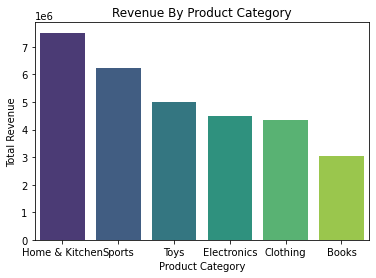

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns
pd_category_revenue=df_category_soldmore.toPandas()
sns.barplot(data=pd_category_revenue,x='category',y='revenue_per_pname',palette='viridis')
plt.xlabel('Product Category')
plt.ylabel('Total Revenue')
plt.title('Revenue By Product Category')
plt.show()

In [0]:
df_category_soldmore.display()
# this is the plot barplot drawn above 

product_name,category,revenue_per_pname
Toaster,Home & Kitchen,7514255.409999999
Yoga Mat,Sports,6235214.489999999
RC Car,Toys,5008281.600000001
Smartphone,Electronics,4480974.46
Jeans,Clothing,4334505.729999999
Biography,Books,3036450.79


### you could plot the distribution of customer spending or visualize the shipping delays for top products- [Matplotlib/Seaborn to visualize trends]

# distribution of customer spending 

- customer spendng is group by customer_id and addthe total_price this is df_customers_plot 
- on this df convert to pandas and make the customers id to clusters 
- as of customers are 990 ids its large to visualize so make clusters of 100 customers as one cluster
- now show the spending avg of the cluster of customers
- make barplot

In [0]:
df_customers_plot=df_orders.select('customer_id','product_id','total_price')\
    .groupBy('customer_id').agg(F.sum(col('total_price')).alias('total'))\
    .orderBy('customer_id')
df_customers_plot.limit(5).display()

customer_id,total
1,48687.24999999999
2,13309.909999999998
3,26942.010000000002
4,30384.48
5,7464.11


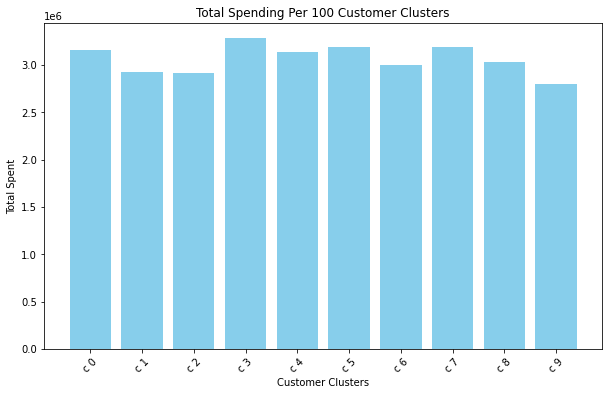

In [0]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

data=df_customers_plot.toPandas()
list_data=data.values.tolist()
cluster_prices=[]
sum=0
customers_cluster=0

for i in range(0,len(list_data)):
    sum+=list_data[i][1]
    if (i+1)%100==0 or i==len(list_data)-1:
        cluster_prices.append([f'c {customers_cluster}',sum])
        sum=0
        customers_cluster+=1

clusters=pd.DataFrame(cluster_prices)
clusters.columns=['cluster_id','Total revenue']
clusters

plt.figure(figsize=(10, 6))
plt.bar(clusters['cluster_id'], clusters['Total revenue'], color='skyblue')
plt.xlabel('Customer Clusters')
plt.ylabel('Total Spent')
plt.title('Total Spending Per 100 Customer Clusters')
plt.xticks(rotation=45)
plt.show()

# visualize the shipping delays for top products

- we already have shiping delays of the products in df_shipping_delays
- top products can get by orderBy quantity of the groupby product_ids
- now we got the top 10 products wheer the quantity of orders done is high
- join the df_shipping delays to the top 10 products to df_avg_delays
- we got the same prduct names twice or thrice so group by product name now and avg the quantity
- now the df_top is optimal top products with their quantities
- now plot them as pie chart

In [0]:
df_top_products=df_orders.select('product_id','quantity')\
    .groupBy('product_id')\
        .agg(F.sum('quantity')\
            .alias('quantity'))\
                .orderBy(F.desc('quantity')).limit(10)
df_avg_delays=df_shipping_delays.groupBy('product_name','product_id')\
    .agg(F.round(F.avg('delay_days'),2).alias('avg_delay_days'))
df_top_products_delays=df_top_products.join(
    df_avg_delays,on='product_id',how='inner'
).orderBy(F.desc('quantity'))
df_top=df_top_products_delays.select('quantity','product_name','avg_delay_days').groupBy('product_name').agg(F.avg('avg_delay_days').alias('avg_delay_days')).orderBy(F.desc('avg_delay_days'))
df_top.display()

product_name,avg_delay_days
Yoga Mat,102.005
Biography,97.1
Toaster,96.57333333333334
Smartphone,95.14333333333333
RC Car,81.57


# plot the df_top

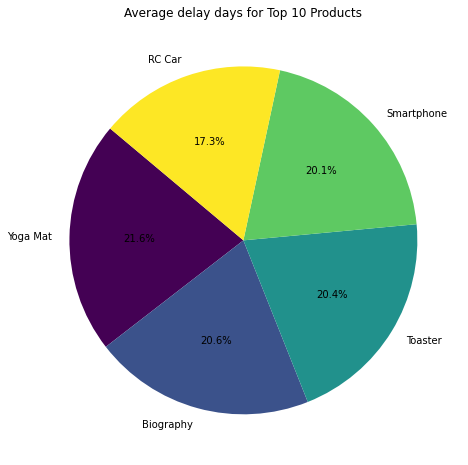

In [0]:
pd_top_products_delays=df_top.toPandas()
plt.figure(figsize=(8,8))
labels = pd_top_products_delays["product_name"]
sizes = pd_top_products_delays["avg_delay_days"]
cmap = plt.get_cmap("viridis")
colors = cmap(np.linspace(0, 1, len(labels)))  
plt.pie(sizes,labels=labels,autopct='%1.1f%%',startangle=140,colors=colors)
plt.title('Average delay days for Top 10 Products')
plt.axis=('equal')
plt.show()